# 🎲 GAN Data Augmentation - Enhanced (Train + Val)\n
This notebook trains a **Conditional DCGAN** and generates synthetic full-scene images with COCO annotations.
The output is directly compatible with `DiceDetectionDataset` used in `3_augmentation_comparison.ipynb`.

**Key Features:**
- Uses local balanced annotations (`Annotations/train_image_balanced.coco.json`) - Zipfian balanced on images
- Downloads images from Roboflow
- Trains conditional DCGAN on dice crops
- Generates full scene images with dice placed on backgrounds
- Outputs COCO-format `_annotations.coco.json` file

## 1. Setup & Installation

In [1]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install roboflow pillow matplotlib seaborn tqdm numpy

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
# Clone the git repository with the code
import os
if not os.path.exists('Dice-Detection'):
    !git clone https://github.com/Adr44mo/Dice-Detection.git
    %cd Dice-Detection
else:
    %cd Dice-Detection

# Add src to path
import sys
sys.path.append('./src')

/content/Dice-Detection


## 2. Import Libraries

### 9.1. Generation Configuration

Configure what datasets to generate (training and/or validation).

In [ ]:
# GENERATION CONFIGURATION
GENERATE_TRAIN = True
GENERATE_VAL = True

# Number of synthetic images to generate
NUM_TRAIN_IMAGES = 600
NUM_VAL_IMAGES = 200

# Output directories
TRAIN_OUTPUT_DIR = 'synthetic_gan_train'
VAL_OUTPUT_DIR = 'synthetic_gan_val'

print(f'Will generate:')
print(f'  Training: {NUM_TRAIN_IMAGES} images' if GENERATE_TRAIN else '  Training: SKIP')
print(f'  Validation: {NUM_VAL_IMAGES} images' if GENERATE_VAL else '  Validation: SKIP')


### 9.2. Generate Training Dataset


In [ ]:
if GENERATE_TRAIN:
    print('\n' + '='*60)
    print('GENERATING TRAINING DATASET')
    print('='*60)
    
    config = {
        'scene_size': (640, 640),
        'dice_size_range': (60, 120),
        'dice_per_image': (1, 4),
        'num_images': NUM_TRAIN_IMAGES,
        'merge_with_original': True,
        'add_to_existing_images': True
    }
    
    train_coco = create_synthetic_coco_dataset(
        netG, BACKGROUND_DIR, TRAIN_OUTPUT_DIR, config, device,
        class_counts=class_counts, latent_dim=LATENT_DIM,
        original_annotations=balanced_annotations,
        original_image_dir=IMAGE_BASE_PATH
    )
    
    # Save to Annotations folder
    import shutil
    os.makedirs('Annotations', exist_ok=True)
    shutil.copy(
        os.path.join(TRAIN_OUTPUT_DIR, 'train', '_annotations.coco.json'),
        'Annotations/train_gan.coco.json'
    )
    print('\n✅ Saved to Annotations/train_gan.coco.json')
else:
    print('Skipping training dataset generation')


### 9.3. Generate Validation Dataset


In [ ]:
if GENERATE_VAL:
    print('\n' + '='*60)
    print('GENERATING VALIDATION DATASET')
    print('='*60)
    
    # Load validation annotations
    with open('Annotations/val_image_balanced.coco.json', 'r') as f:
        val_annotations = json.load(f)
    
    # Calculate class counts for validation
    val_class_counts = {}
    for ann in val_annotations['annotations']:
        cat_id = str(ann['category_id'])
        val_class_counts[cat_id] = val_class_counts.get(cat_id, 0) + 1
    
    print(f'Validation class distribution: {val_class_counts}')
    
    config = {
        'scene_size': (640, 640),
        'dice_size_range': (60, 120),
        'dice_per_image': (1, 4),
        'num_images': NUM_VAL_IMAGES,
        'merge_with_original': True,
        'add_to_existing_images': True
    }
    
    val_coco = create_synthetic_coco_dataset(
        netG, BACKGROUND_DIR, VAL_OUTPUT_DIR, config, device,
        class_counts=val_class_counts, latent_dim=LATENT_DIM,
        original_annotations=val_annotations,
        original_image_dir=f'{dataset.location}/valid'
    )
    
    # Save to Annotations folder
    import shutil
    os.makedirs('Annotations', exist_ok=True)
    shutil.copy(
        os.path.join(VAL_OUTPUT_DIR, 'train', '_annotations.coco.json'),
        'Annotations/val_gan.coco.json'
    )
    print('\n✅ Saved to Annotations/val_gan.coco.json')
else:
    print('Skipping validation dataset generation')


### 9.4. Summary


In [ ]:
print('\n' + '='*60)
print('GENERATION COMPLETE')
print('='*60)

if GENERATE_TRAIN:
    print(f'✓ Training: Annotations/train_gan.coco.json')
    print(f'  Images: {TRAIN_OUTPUT_DIR}/train/')

if GENERATE_VAL:
    print(f'✓ Validation: Annotations/val_gan.coco.json')
    print(f'  Images: {VAL_OUTPUT_DIR}/train/')

print('\nThese can now be used in 3_augmentation_comparison_enhanced.ipynb by setting:')
print('  USE_GAN_DATASET = True')
print('  TRAIN_ANNOTATION = "train_gan.coco.json"')
print('  VAL_ANNOTATION = "val_gan.coco.json"')


## 3. Download Dataset from Roboflow

In [4]:
from roboflow import Roboflow

rf = Roboflow(api_key="kd9lS9tvh5StEQtSA6i9")
project = rf.workspace("workspace-spezm").project("dice-0sexk")
dataset = project.version(2).download("coco")
print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /content/Dice-Detection/dice-2


## 4. Load Balanced Annotations

We use the local balanced annotations (`train_image_balanced.coco.json`) which contains a Zipfian-balanced subset of images, while using the images downloaded from Roboflow.

In [5]:
# Load balanced annotations from local file
BALANCED_ANNOTATION_FILE = 'Annotations/train_image_balanced.coco.json'
IMAGE_BASE_PATH = f'{dataset.location}/train'

with open(BALANCED_ANNOTATION_FILE, 'r') as f:
    balanced_annotations = json.load(f)

print(f"Loaded balanced annotations from: {BALANCED_ANNOTATION_FILE}")
print(f"Images: {len(balanced_annotations['images'])}")
print(f"Annotations: {len(balanced_annotations['annotations'])}")
print(f"Categories: {len(balanced_annotations['categories'])}")

# Extract categories (only numeric dice classes)
categories = {cat['id']: cat['name'] for cat in balanced_annotations['categories']}
valid_categories = {k: v for k, v in categories.items() if v.isdigit()}
print(f"\nValid dice categories: {valid_categories}")

# Create image lookup
image_id_to_info = {
    img['id']: {'file_name': img['file_name'], 'width': img['width'], 'height': img['height']}
    for img in balanced_annotations['images']
}

Loaded balanced annotations from: Annotations/train_image_balanced.coco.json
Images: 1219
Annotations: 1347
Categories: 7

Valid dice categories: {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'}


## 5. Extract Dice Crops

Crop dice from downloaded images using bounding boxes from balanced annotations.

In [6]:
IMG_SIZE = 64
OUTPUT_DIR = 'gan_training_data'

os.makedirs(OUTPUT_DIR, exist_ok=True)
for cat_name in valid_categories.values():
    os.makedirs(os.path.join(OUTPUT_DIR, cat_name), exist_ok=True)

class_counts = Counter()
print("\nCropping dice images from balanced dataset...")

for ann in tqdm(balanced_annotations['annotations']):
    category_id = ann['category_id']
    if category_id not in valid_categories:
        continue

    image_id = ann['image_id']
    bbox = ann['bbox']
    category_name = valid_categories[category_id]
    image_info = image_id_to_info.get(image_id)

    if not image_info:
        continue

    image_path = os.path.join(IMAGE_BASE_PATH, image_info['file_name'])

    try:
        img = Image.open(image_path).convert('RGB')
        x_min, y_min, width, height = [int(b) for b in bbox]
        x_max, y_max = x_min + width, y_min + height
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(img.width, x_max), min(img.height, y_max)

        cropped = img.crop((x_min, y_min, x_max, y_max))
        resized = cropped.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)

        output_filename = f"{image_id}_{ann['id']}.png"
        output_path = os.path.join(OUTPUT_DIR, category_name, output_filename)
        resized.save(output_path)
        class_counts[category_name] += 1
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

print("\n✅ Cropping complete!")
for cat in sorted(class_counts.keys()):
    print(f"  Class {cat}: {class_counts[cat]} images")


Cropping dice images from balanced dataset...


100%|██████████| 1347/1347 [00:09<00:00, 148.88it/s]


✅ Cropping complete!
  Class 1: 427 images
  Class 2: 350 images
  Class 3: 250 images
  Class 4: 150 images
  Class 5: 100 images
  Class 6: 70 images


## 6. GAN Architecture & Hyperparameters

In [7]:
# Hyperparameters
# Hyperparameters
LATENT_DIM = 100
NUM_CLASSES = 6
EMBED_DIM = 50
NGF = 64
NDF = 64
NC = 3
BATCH_SIZE = 32
NUM_EPOCHS = 500  # 🔴 CHANGE: était 200, maintenant 500 pour meilleure qualité
LR = 0.0002
BETA1 = 0.5

print(f"Latent dimension: {LATENT_DIM}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of epochs: {NUM_EPOCHS}")

Latent dimension: 100
Number of classes: 6
Batch size: 32
Number of epochs: 500


In [8]:
# Initialize models from src.gan
netG = Generator(LATENT_DIM, NUM_CLASSES, EMBED_DIM, NGF, NC).to(device)
netD = Discriminator(NUM_CLASSES, NDF, NC, IMG_SIZE).to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)

print(f"Generator params: {sum(p.numel() for p in netG.parameters()):,}")
print(f"Discriminator params: {sum(p.numel() for p in netD.parameters()):,}")

Generator params: 3,986,604
Discriminator params: 2,791,168


## 7. Prepare Dataset & DataLoader

In [9]:
class DiceDataset(Dataset):
    """Dataset for loading cropped dice images for GAN training."""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for label_idx, label_name in enumerate(['1', '2', '3', '4', '5', '6']):
            label_dir = os.path.join(root_dir, label_name)
            if os.path.exists(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((os.path.join(label_dir, img_name), label_idx))
        print(f"Loaded {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dice_dataset = DiceDataset(OUTPUT_DIR, transform=transform)
dataloader = DataLoader(dice_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

print(f"Number of batches: {len(dataloader)}")

Loaded 1347 samples
Number of batches: 42


## 8. Training

In [10]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

G_losses, D_losses = [], []

print("Starting Training...")
for epoch in range(NUM_EPOCHS):
    epoch_D_loss, epoch_G_loss = 0, 0

    for real_imgs, labels in dataloader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        real_label = torch.ones(batch_size, device=device) * 0.9
        fake_label = torch.zeros(batch_size, device=device) + 0.1

        # Train Discriminator
        netD.zero_grad()
        output_real = netD(real_imgs, labels)
        errD_real = criterion(output_real, real_label)
        errD_real.backward()

        noise = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_imgs = netG(noise, labels)
        output_fake = netD(fake_imgs.detach(), labels)
        errD_fake = criterion(output_fake, fake_label)
        errD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        output = netD(fake_imgs, labels)
        errG = criterion(output, real_label)
        errG.backward()
        optimizerG.step()

        epoch_D_loss += (errD_real + errD_fake).item()
        epoch_G_loss += errG.item()

    G_losses.append(epoch_G_loss / len(dataloader))
    D_losses.append(epoch_D_loss / len(dataloader))

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"[{epoch+1:3d}/{NUM_EPOCHS}] Loss_D: {D_losses[-1]:.4f} | Loss_G: {G_losses[-1]:.4f}")

print("\n✅ Training complete!")

Starting Training...
[  1/500] Loss_D: 1.5618 | Loss_G: 3.7803
[ 20/500] Loss_D: 0.9038 | Loss_G: 2.5722
[ 40/500] Loss_D: 0.8871 | Loss_G: 2.3145
[ 60/500] Loss_D: 0.7854 | Loss_G: 2.2672
[ 80/500] Loss_D: 0.7071 | Loss_G: 2.3030
[100/500] Loss_D: 0.7341 | Loss_G: 2.3518
[120/500] Loss_D: 0.8554 | Loss_G: 2.1951
[140/500] Loss_D: 0.8159 | Loss_G: 2.2319
[160/500] Loss_D: 0.7534 | Loss_G: 2.2288
[180/500] Loss_D: 0.7125 | Loss_G: 2.1297
[200/500] Loss_D: 0.7199 | Loss_G: 2.2111
[220/500] Loss_D: 0.8047 | Loss_G: 2.3880
[240/500] Loss_D: 0.7114 | Loss_G: 2.3161
[260/500] Loss_D: 0.7241 | Loss_G: 2.2644
[280/500] Loss_D: 0.7313 | Loss_G: 2.3405
[300/500] Loss_D: 0.7300 | Loss_G: 2.2932
[320/500] Loss_D: 0.7103 | Loss_G: 2.1801
[340/500] Loss_D: 0.7316 | Loss_G: 2.2292
[360/500] Loss_D: 0.7567 | Loss_G: 2.3552
[380/500] Loss_D: 0.6955 | Loss_G: 2.1521
[400/500] Loss_D: 0.7369 | Loss_G: 2.3014
[420/500] Loss_D: 0.7316 | Loss_G: 2.3009
[440/500] Loss_D: 0.7756 | Loss_G: 2.3265
[460/500] Los

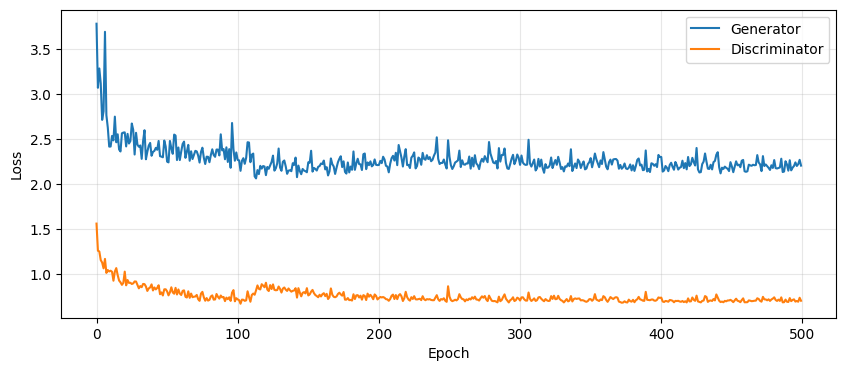

In [11]:
# Plot training losses
plt.figure(figsize=(10, 4))
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('training_losses.png', dpi=150)
plt.show()

## 9. Generate COCO-Format Dataset

Create full scene images with dice on backgrounds and COCO annotations using functions from `src.gan`.

In [12]:
# Extract background images from downloaded dataset
BACKGROUND_DIR = 'backgrounds'
train_images_dir = f'{dataset.location}/train'

print("Extracting background samples from training images...")
bg_count = extract_backgrounds(train_images_dir, BACKGROUND_DIR, num_backgrounds=50)
print(f"Extracted {bg_count} background images")

Extracting background samples from training images...
Extracted 50 background images


In [13]:
# Configuration for synthetic dataset generation
SYNTHETIC_COCO_DIR = 'synthetic_coco_dataset'

# Calculate images needed per class for balancing
current_counts = {str(i): class_counts.get(str(i), 0) for i in range(1, 7)}
target_count = max(current_counts.values())
images_to_generate = {k: max(0, target_count - v) for k, v in current_counts.items()}

print(f"Current class distribution: {current_counts}")
print(f"Target count per class: {target_count}")

# We'll add synthetic dice to existing images to avoid overlap issues
num_images_to_augment = len(balanced_annotations['images']) // 2  # Augment half of the images
print(f"Will add synthetic dice to {num_images_to_augment} existing images")

# Generation config - ADD synthetic dice to existing images
gen_config = {
    'scene_size': (640, 640),
    'dice_size_range': (60, 120),
    'dice_per_image': (1, 3),  # Add 1-3 dice per image
    'num_images': num_images_to_augment,
    'merge_with_original': True,  # 🔴 NEW: Merge with original annotations
    'add_to_existing_images': True  #  🔴 NEW: Add to existing images instead of creating new ones
}

# Generate augmented COCO dataset (merges with original)
coco_data = create_synthetic_coco_dataset(
    generator=netG,
    background_dir=BACKGROUND_DIR,
    output_dir=SYNTHETIC_COCO_DIR,
    config=gen_config,
    device=device,
    class_counts=current_counts,
    latent_dim=LATENT_DIM,
    original_annotations=balanced_annotations,  # 🔴 NEW: Pass original annotations
    original_image_dir=IMAGE_BASE_PATH  # 🔴 NEW: Pass original image directory
)

Current class distribution: {'1': 427, '2': 350, '3': 250, '4': 150, '5': 100, '6': 70}
Target count per class: 427
Will add synthetic dice to 609 existing images
Merging with original annotations...
Starting from image_id=1227, annotation_id=2790
Generating 609 synthetic scenes...
Adding synthetic dice to existing images...


100%|██████████| 609/609 [00:04<00:00, 137.61it/s]


✅ Generated dataset with 1219 total images and 2555 total annotations

Synthetic dice added per class:
  Class 1: 0 dice
  Class 2: 77 dice
  Class 3: 177 dice
  Class 4: 278 dice
  Class 5: 328 dice
  Class 6: 348 dice


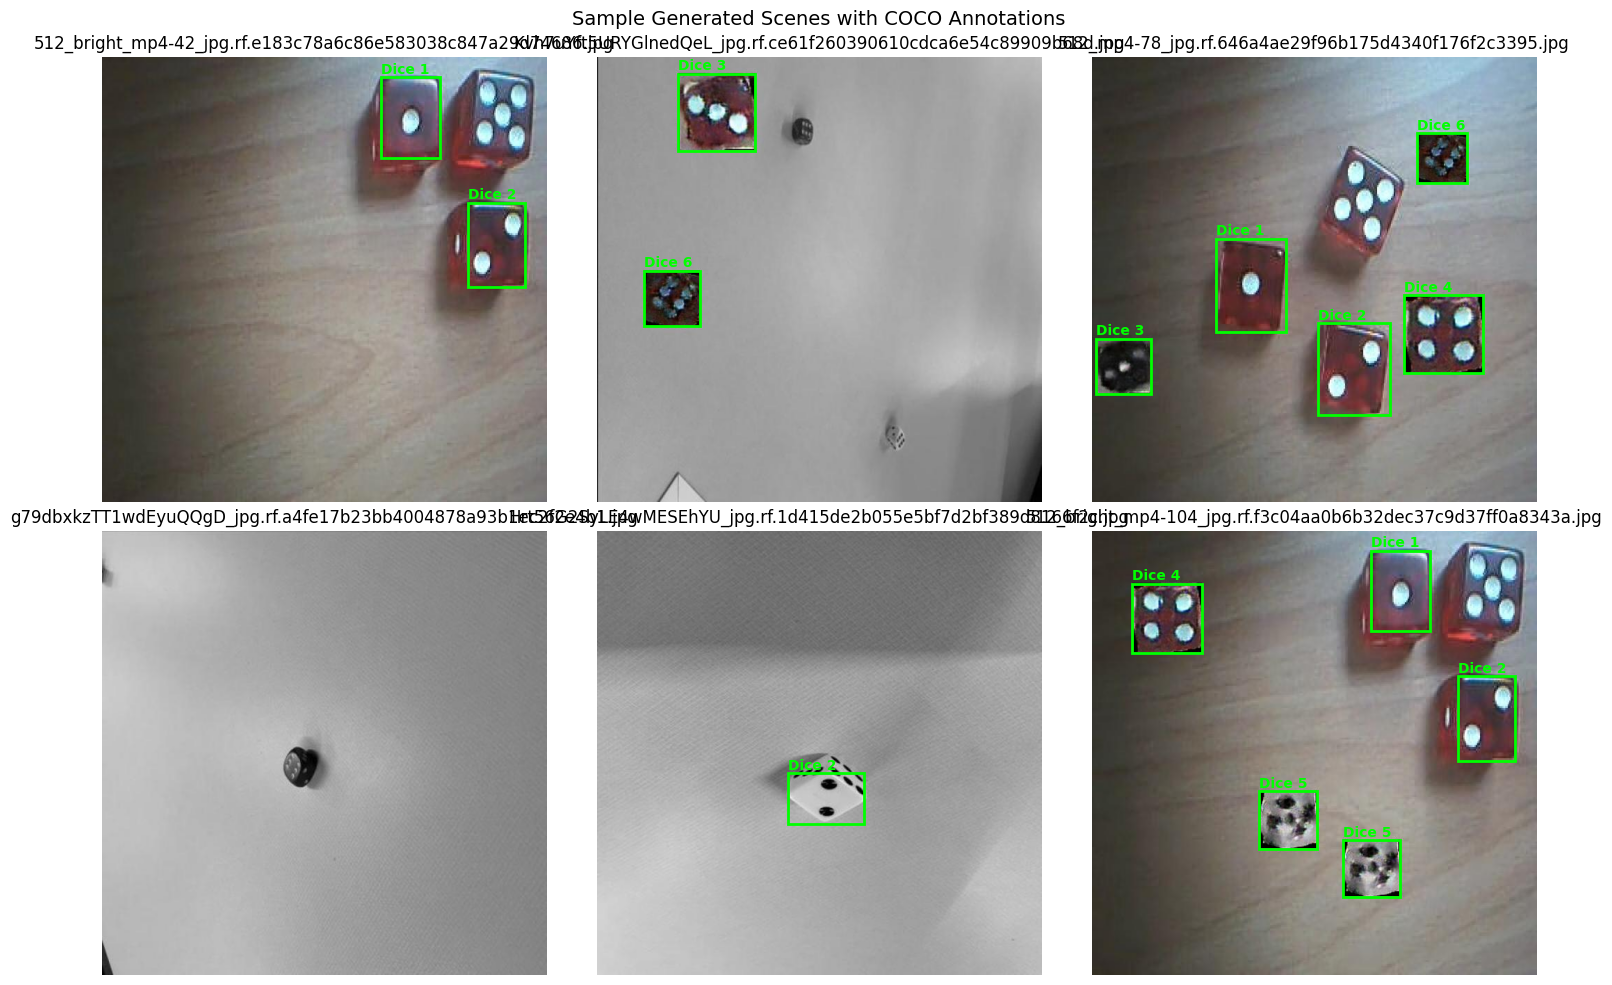

In [14]:
# Visualize sample generated scenes
import matplotlib.patches as patches

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sample_images = random.sample(coco_data['images'], min(6, len(coco_data['images'])))

for ax, img_info in zip(axes, sample_images):
    img_path = os.path.join(SYNTHETIC_COCO_DIR, 'train', img_info['file_name'])
    img = Image.open(img_path)
    ax.imshow(img)

    # Draw bounding boxes
    for ann in coco_data['annotations']:
        if ann['image_id'] == img_info['id']:
            x, y, w, h = ann['bbox']
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 5, f"Dice {ann['category_id']}", color='lime', fontsize=10, weight='bold')

    ax.axis('off')
    ax.set_title(img_info['file_name'])

plt.suptitle('Sample Generated Scenes with COCO Annotations', fontsize=14)
plt.tight_layout()
plt.savefig('sample_coco_scenes.png', dpi=150)
plt.show()

## 10. Verify Compatibility with DiceDetectionDataset

In [15]:
# Test loading with DiceDetectionDataset from src
try:
    synthetic_dataset = DiceDetectionDataset(
        root_dir=os.path.join(SYNTHETIC_COCO_DIR, 'train'),
        annotation_file='_annotations.coco.json',
        split='train'
    )

    print(f"✅ Successfully loaded synthetic dataset!")
    print(f"   Number of images: {len(synthetic_dataset)}")
    print(f"   Number of classes: {synthetic_dataset.num_classes}")
    print(f"   Class distribution: {synthetic_dataset.get_class_distribution()}")

    # Test getting an item
    image, target = synthetic_dataset[0]
    print(f"\n   Sample image shape: {image.shape}")
    print(f"   Sample boxes: {target['boxes'].shape}")
    print(f"   Sample labels: {target['labels']}")

except Exception as e:
    print(f"Could not test with DiceDetectionDataset: {e}")
    print("The dataset structure is still COCO-compatible.")

✅ Successfully loaded synthetic dataset!
   Number of images: 1219
   Number of classes: 7
   Class distribution: {'1': 427, '2': 427, '3': 427, '4': 428, '5': 428, '6': 418}

   Sample image shape: torch.Size([3, 640, 640])
   Sample boxes: torch.Size([2, 4])
   Sample labels: tensor([5, 4])


## 11. Save Model

In [16]:
MODEL_DIR = 'gan_models'
os.makedirs(MODEL_DIR, exist_ok=True)

torch.save({
    'generator_state_dict': netG.state_dict(),
    'discriminator_state_dict': netD.state_dict(),
    'epoch': NUM_EPOCHS,
    'G_losses': G_losses,
    'D_losses': D_losses,
}, os.path.join(MODEL_DIR, 'conditional_dcgan_dice.pth'))

print(f"✅ Model saved to {MODEL_DIR}/conditional_dcgan_dice.pth")

✅ Model saved to gan_models/conditional_dcgan_dice.pth


## 🚀 Summary

This notebook:
1. ✅ Downloaded images from Roboflow
2. ✅ Used local balanced annotations (`Annotations/train_image_balanced.coco.json`) - Zipfian balanced on images
3. ✅ Extracted dice crops from balanced subset
4. ✅ Trained Conditional DCGAN on dice crops (500 epochs for better quality)
5. ✅ Added synthetic dice to existing images (avoiding overlap with original dice)
6. ✅ Merged original and synthetic annotations into unified dataset

**Key improvements:**
- 🎯 Original annotations are preserved and merged with synthetic ones
- 🚫 Synthetic dice avoid overlapping with existing dice in images
- 📈 Longer training (500 epochs) for higher quality GAN output

**Output files:**
- `synthetic_coco_dataset/train/` - Original + augmented images
- `synthetic_coco_dataset/train/_annotations.coco.json` - Merged COCO annotations (original + synthetic)
- `gan_models/conditional_dcgan_dice.pth` - Trained GAN

**Usage in other notebooks:**
```python
from src.dataset import DiceDetectionDataset

# This now contains BOTH original and synthetic dice!
augmented_train = DiceDetectionDataset(
    root_dir='synthetic_coco_dataset/train',
    annotation_file='_annotations.coco.json',
    split='train'
)